# Разбор решения хакатона
## Дообучение SAM2

In [1]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Counting objects: 100% (477/477), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 1070 (delta 322), reused 279 (delta 279), pack-reused 593 (from 1)
Receiving objects: 100% (1070/1070), 115.76 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/kaggle/working/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.3 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [2]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
# !wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
# !wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
# !wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2025-04-04 21:10:44--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.169.149.41, 3.169.149.5, 3.169.149.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.169.149.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   161MB/s    in 0.9s    

2025-04-04 21:10:45 (161 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]



In [3]:
%cd segment-anything-2

[Errno 2] No such file or directory: 'segment-anything-2'
/kaggle/working/segment-anything-2


In [4]:
!wget https://storage.yandexcloud.net/ds-ods/files/files/edd91118/train1.zip
!wget https://storage.yandexcloud.net/ds-ods/files/files/e5a98368/train2.zip
!wget https://storage.yandexcloud.net/ds-ods/files/files/a95eacf7/train3.zip
!wget https://storage.yandexcloud.net/ds-ods/files/files/a9a3642d/train4.zip
!wget https://storage.yandexcloud.net/ds-ods/files/files/adacb253/val.zip
!wget https://storage.yandexcloud.net/ds-ods/files/files/b5ac09fa/annotations.zip

--2025-04-04 21:10:45--  https://storage.yandexcloud.net/ds-ods/files/files/edd91118/train1.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 974593914 (929M) [application/x-zip-compressed]
Saving to: ‘train1.zip’

train1.zip          100%[===================>] 929.44M  18.4MB/s    in 52s     

2025-04-04 21:11:38 (17.8 MB/s) - ‘train1.zip’ saved [974593914/974593914]

--2025-04-04 21:11:38--  https://storage.yandexcloud.net/ds-ods/files/files/e5a98368/train2.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857951397 (818M) [application/x-zip-compressed]
Saving to: ‘train2.zip’

train2.zi

In [ ]:
!unzip train1.zip
!unzip train2.zip
!unzip train3.zip
!unzip train4.zip
!unzip val.zip
!unzip annotations.zip

In [10]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [8]:
import shutil
import os

train_path = "train"
for folder_name in ["train1", "train2", "train3", "train4"]:
  for file_name in os.listdir(folder_name):
    src = os.path.join(folder_name, file_name)
    shutil.move(src, train_path)

In [78]:

import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import json

import random
import torch.nn.functional as F

with open("val_annotations.json", "r") as f:
  val_data = json.load(f)

with open("train_annotations.json", "r") as f:
  train_data = json.load(f)

In [79]:
from pycocotools import _mask

Зафиксировать seed для воспроизведения обучения.

In [80]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()

## Считывание данных для обучения

In [81]:
import cv2
def read_batch(data, data_path):
   # Select a random entry
  ent = data['annotations'][np.random.randint(len(data['annotations']))]

  ind = 0
  while data['images'][ind]['id'] != ent['image_id']:
    ind += 1
  image_path = data['images'][ind]['file_name']
  image_path = os.path.join(data_path, image_path)
  Img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
  binary_mask = np.zeros((693, 1344), dtype=np.uint8)
  for pts in ent['segmentation']:
    # Шаг 1: Разделить на пары (x, y)
    points = [[pts[i], pts[i + 1]] for i in range(0, len(pts), 2)]

    # Шаг 2: Обернуть в список (даже если один полигон)
    polygon = [points]

    # Шаг 3: Преобразовать в NumPy массив с типом int32
    pts_array = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(binary_mask, pts_array , color=1)

  # Erode the combined binary mask to avoid boundary points
  eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

  points = []
  # Get all coordinates inside the eroded mask and choose random points
  coords = np.argwhere(eroded_mask > 0)
  if len(coords) > 0:
      yx = coords[np.random.randint(len(coords))]  # Randomly select a point
      points.append([yx[1], yx[0]])  # Append in [x, y] format (col, row)

  points = np.array(points)
  binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
  binary_mask = binary_mask.transpose((2, 0, 1))
  points = np.expand_dims(points, axis=1)

  # Return the image, binarized mask, points, and number of masks
  return Img, binary_mask, points, 1

## Подготовка кода для обучения

In [82]:
sam2_checkpoint = "sam2_hiera_tiny.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_t.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [83]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 1000 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

In [17]:
!pwd

/content/segment-anything-2


In [84]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, 'train')
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue
       image = image.copy()
       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.5178927177970583
Step 200:	 Accuracy (IoU) =  0.7181107265846879
Step 300:	 Accuracy (IoU) =  0.8064834842621518
Step 400:	 Accuracy (IoU) =  0.8564500209429826
Step 500:	 Accuracy (IoU) =  0.8529836108876636
Step 600:	 Accuracy (IoU) =  0.8776147616335299
Step 700:	 Accuracy (IoU) =  0.8705570728198178
Step 800:	 Accuracy (IoU) =  0.8648320372225159
Step 900:	 Accuracy (IoU) =  0.8868312397167352
Step 1000:	 Accuracy (IoU) =  0.8501802978528112


In [85]:
# Setting the device to use for computations ('cuda' indicates GPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    torch.cuda.set_device(0)

In [ ]:
! wget https://storage.yandexcloud.net/ds-ods/files/files/2ad601fd/test.zip
! unzip test.zip

In [ ]:
!pip install ultralytics

In [87]:
from ultralytics import YOLO

yolo_model = YOLO("yolo11n.pt", task="detect")

In [24]:
os.makedirs("images", exist_ok=True)
os.makedirs("images/train", exist_ok=True)
os.makedirs("images/val", exist_ok=True)

In [25]:
from tqdm import tqdm

src_dst_copy_dirs = {
    "train": "images/train",
    "val": "images/val"
}

for src_dir, dst_dir in src_dst_copy_dirs.items():
    print(f"Copying from {src_dir}...")
    for filename in tqdm(os.listdir(src_dir)):
        shutil.copy(f"{src_dir}/{filename}", f"{dst_dir}/{filename}")
    print()

Copying from train...


100%|██████████| 16631/16631 [00:07<00:00, 2225.27it/s]



Copying from val...


100%|██████████| 8557/8557 [00:02<00:00, 3828.49it/s]

In [33]:
os.makedirs("labels", exist_ok=True)
os.makedirs("labels/train", exist_ok=True)
os.makedirs("labels/val", exist_ok=True)

In [88]:
from pycocotools.coco import COCO

train_coco = COCO("train_annotations.json")
val_coco = COCO("val_annotations.json")

loading annotations into memory...
Done (t=7.92s)
creating index...
index created!
loading annotations into memory...
Done (t=4.45s)
creating index...
index created!


In [28]:
labels_dirs_with_cocos = {
    "labels/train": train_coco,
    "labels/val": val_coco
}

for dst_dir in labels_dirs_with_cocos:
    print(f"Clearing files in {dst_dir}...")
    for filename in tqdm(os.listdir(dst_dir)):
        os.remove(f"{dst_dir}/{filename}")
    print()


for dst_dir, coco_file in labels_dirs_with_cocos.items():
    print(f"Forming labels from {dst_dir}...")
    for img_id in tqdm(coco_file.getImgIds()):
        for ann in coco_file.loadAnns(coco_file.getAnnIds(img_id)):
            if len(ann["bbox"]) != 4:
                continue

            img = coco_file.loadImgs(img_id)[0]
            filename = img["file_name"]
            filename = filename[:filename.rfind(".")] + ".txt"

            img_width = img["width"]
            img_height = img["height"]
            x, y, width, height = ann["bbox"]
            center_x = (x + width / 2) / img_width
            center_y = (y + height / 2) / img_height
            width = width / img_width
            height = height / img_height

            cat_id = ann["category_id"]

            out_path = f"{dst_dir}/{filename}"
            with open(out_path, "a") as out:
                print(f"{cat_id} {center_x} {center_y} {width} {height}", file=out)
    print()


Clearing files in labels/train...


0it [00:00, ?it/s]



Clearing files in labels/val...


0it [00:00, ?it/s]



Forming labels from labels/train...


100%|██████████| 16631/16631 [00:01<00:00, 16175.36it/s]



Forming labels from labels/val...


100%|██████████| 8557/8557 [00:00<00:00, 16381.20it/s]

In [89]:
import yaml

yolo_config = {
    "path": os.getcwd(),
    "train": "images/train",
    "val": "images/val",
    "names": {
        0: "Animal"
    }
}

with open("config.yaml", "w") as out:
    yaml.dump(yolo_config, out)

In [90]:
yolo_results = yolo_model.train(data="config.yaml", epochs=1)

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=config.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

AMP: checks passed ✅


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becaus

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/segment-anything-2/labels/val.cache... 8557 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8557/8557 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1040 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:1323: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:1325: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but th

                   all       8557       9551      0.863       0.72      0.807      0.597


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



1 epochs completed in 0.097 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

                   all       8557       9551      0.861      0.721      0.806      0.597


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


In [91]:
yolo_model.load("runs/detect/train/weights/best.pt")

Transferred 499/499 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [198]:
test_predictions = yolo_model.predict("test", stream=True)

In [93]:
from pycocotools import mask as coco_mask


def masks_to_rle(binary_mask):
    """
    Convert binary_mask to COCO RLE format.

    Args:
        binary_mask.

    Returns:
        list: List of RLE-encoded masks.
    """
    binary_mask = binary_mask.astype(np.uint8)

    # Encode mask using COCO RLE format
    rle = coco_mask.encode(np.asfortranarray(binary_mask))

    print(rle)
    # Ensure COCO compliance
    rle['counts'] = rle['counts']


    return rle

In [94]:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

<All keys matched successfully>

In [199]:
import numpy as np
from IPython.display import clear_output

predictions = []
for result in tqdm(test_predictions):
    clear_output(wait=True)

    boxes = result.boxes
    if len(boxes.xyxy) != 0:
        image_path = result.path
        Img = cv2.imread(image_path)[..., ::-1]
        # Perform inference and predict masks
        with torch.no_grad():
            image = Img.copy()
            predictor.set_image(image)
            for detection in boxes.xyxy:
                cx = (detection[0].cpu() + detection[2].cpu()) / 2
                cy = (detection[1].cpu() + detection[3].cpu()) / 2
                input_points = np.array([[cx, cy]])
                masks, scores, logits = predictor.predict(
                    point_coords=[input_points],
                    point_labels=np.ones([input_points.shape[0], 1])
                )
                rle = masks_to_rle(masks[0])
                file_name = image_path.split('/')[-1]
                predictions.append({
                    "image_name": file_name,
                    "category_id": "0",  # ID категории
                    "bbox": detection,  # Координаты bounding box
                    "score": scores[0],  # Оценка уверенности
                    "segmentation": {
                        "size" : rle["size"],
                        "counts" : rle["counts"].decode("utf-8")
                    }  # Сегментация в формате RLE
                })

104it [00:19,  5.39it/s]


KeyboardInterrupt: 

In [193]:
ann = predictions[23]

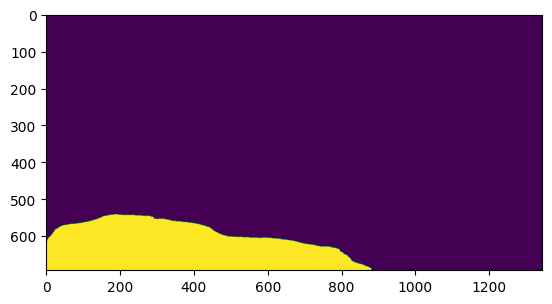

In [194]:
import matplotlib.pyplot as plt

plt.imshow(coco_mask.decode(ann["segmentation"]))

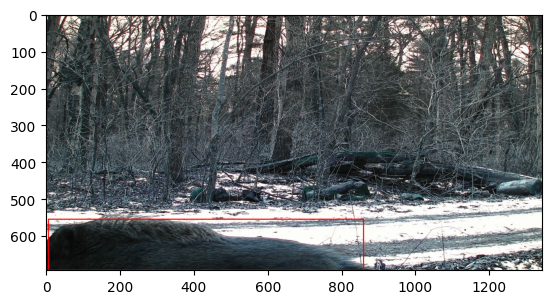

In [195]:
img = cv2.imread("test/" + ann["image_name"])
cv2.rectangle(img, (int(ann["bbox"][0]), int(ann["bbox"][1])), (int(ann["bbox"][2]), int(ann["bbox"][3])), color=(255, 0, 0), thickness=2)

plt.imshow(img)

In [ ]:
import os
import json

output_folder = "./"
# Сохранение предсказаний в JSON
predictions_file = os.path.join(output_folder, "submission.json")
with open(predictions_file, "w") as f:
    json.dump(predictions, f, indent=4)

print(f"Обработка завершена. Результаты сохранены в папке: {output_folder}")